# Create protein expression atlas

Copied source code from notebook from Tine Claeys (see folder *"Reference"*)

In [2]:
import pandas as pd
import mysql.connector
import numpy as np

In [3]:
conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


In [3]:
assaysql = "SELECT assay_id, peptide_id, quantification FROM peptide_to_assay"
assayData = pd.read_sql_query(assaysql, conn)
assayData.head()

,assay_id,peptide_id,quantification
0,30960,110730450,2.0
1,30961,110730450,2.0
2,30995,110730450,1.0
3,31006,110730450,1.0
4,31007,110730450,1.0


In [4]:
assayData.assay_id.nunique()

1943

Get all peptide to protein relations

In [5]:
pepsql = "SELECT peptide_to_protein.peptide_id, peptide_to_protein.uniprot_id FROM peptide_to_protein"
pepData = pd.read_sql_query(pepsql, conn)
pepData.head()

,peptide_id,uniprot_id
0,122045961,A0A024QZ42
1,120203377,A0A024QZX5
2,122405701,A0A024R1R8
3,118966811,A0A024RA28
4,117787530,A0A024RAC6


In [7]:
pepData.shape

(424682, 2)

Get sequence length for all proteins in the database

In [6]:
seqsql = "SELECT uniprot_id, length FROM protein WHERE length IS NOT NULL"
seqData = pd.read_sql_query(seqsql, conn)
seqData["length"] = pd.to_numeric(seqData['length'], errors = "coerce")
seqData.head()

,uniprot_id,length
0,A0A024RBG1,181.0
1,A0A075B6H7,116.0
2,A0A075B6I1,120.0
3,A0A075B6I3,123.0
4,A0A075B6L6,115.0


In [13]:
seqData.shape

(16893, 2)

Select proteotypic peptides (peptide with 1 peptide to protein relation)

In [8]:
proteotypicData = pepData.groupby("peptide_id").filter(lambda x: len(x) == 1)
print(proteotypicData.shape)
proteotypicData.head()

(422679, 2)


,peptide_id,uniprot_id
0,122045961,A0A024QZ42
1,120203377,A0A024QZX5
2,122405701,A0A024R1R8
3,118966811,A0A024RA28
4,117787530,A0A024RAC6


Select proteins which have more than 2 proteotypic peptides

In [9]:
proteins = proteotypicData.groupby("uniprot_id").filter(lambda x: len(x) > 0)
proteins.shape

(422679, 2)

Drop non human proteins

In [24]:
non_human = proteins[proteins.uniprot_id.str.contains(pat = r"[-_|]")].uniprot_id.unique().tolist()
proteins = proteins[~proteins["uniprot_id"].isin(non_human)]

In [25]:
proteins.shape

(422052, 2)

In [53]:
non_human_proteins = non_human = """ADH1_YEAST,,,
ALBU_BOVIN,,,
ALDOA_RABIT,,,
BGAL_ECOLI,,,
CAH2_BOVIN,,,
CAS1_BOVIN,,,
CAS2_BOVIN,,,
CASB_BOVIN,,,
CASK_BOVIN,,,
CYC_HORSE,,,
DHE3_BOVIN,,,
GAG_SCVLA,,,
GFP_AEQVI,,,
K1C15_SHEEP,,,
K1M1_SHEEP,,,
K1M2_SHEEP,,,
K2M1_SHEEP,,,
K2M2_SHEEP,,,
K2M3_SHEEP,,,
KRA3_SHEEP,,,
KRA61_SHEEP,,,
LALBA_BOVIN,,,
LYSC_CHICK,,,
LYSC_LYSEN,,,
MYG_HORSE,,,
REF_HEVBR,,,
SRPP_HEVBR,,,
TRY1_BOVIN,,,
TRYP_PIG""".split(",,,\n")
proteins = proteins[~proteins["uniprot_id"].isin(non_human_proteins)]

Merge assays containing spectral counts and proteins

In [29]:
protData = pd.merge(assayData, proteins, on = "peptide_id").sort_values(["assay_id", "uniprot_id"])
del protData['peptide_id']
print(protData.shape)
protData.head(10)

(7064150, 3)


,assay_id,quantification,uniprot_id
45244,30960,5.0,A0AV96
68573,30960,2.0,A0AVT1
87471,30960,2.0,A0AVT1
112813,30960,3.0,A0AVT1
44881,30960,3.0,A0FGR8
48719,30960,2.0,A0FGR8
78346,30960,1.0,A0MZ66
47985,30960,7.0,A1L0T0
47793,30960,1.0,A1L170
26046,30960,1.0,A2A4G1


Split data per assay

In [30]:
protData.assay_id.nunique()

1943

In [31]:
assays = protData['assay_id'].unique()
DataFramaDict = {elem: pd.DataFrame for elem in assays}
for key in DataFramaDict.keys():
    DataFramaDict[key] = protData[:][protData["assay_id"] ==  key]

DataFramaDict2 = DataFramaDict.copy()

Calculate NSAF score for each protein per assay

In [32]:
for count, key in enumerate(DataFramaDict2.keys()):
    sumSaf = 0
    assay = DataFramaDict2[key]
    assay.pop("assay_id")

    #calculate sum of spectral counts for each protein
    grouped = DataFramaDict2[key].groupby("uniprot_id").sum().reset_index()
    seqAddedDF = pd.merge(grouped, seqData, on = "uniprot_id")
    seqAddedDF.insert(loc = 2, column = 'SAF', value = 0)
    seqAddedDF.insert(loc = 3, column = 'NSAF', value = 0)
    
    #Calculate SAF score for each protein by dividing sum of spectral counts by protein length
    for index, row in seqAddedDF.iterrows():
        saf = row['quantification']/row['length']
        seqAddedDF.loc[index, 'SAF'] = saf
        # calculate sum of SAF scores in assay
        sumSaf += saf

    # Calculate NSAF score by normalizing each SAF score
    seqAddedDF["NSAF"] = seqAddedDF["SAF"] / sumSaf
    
    del seqAddedDF['length']
    del seqAddedDF['quantification']
    del seqAddedDF['SAF']
    seqAddedDF.insert(loc = 0, column = 'assay_id', value = key)
    DataFramaDict2[key] = seqAddedDF


In [33]:
proteinData = pd.DataFrame()

for key in DataFramaDict2.keys():
    proteinData = proteinData.append(DataFramaDict2[key])

In [34]:
proteinData.head()

,assay_id,uniprot_id,NSAF
0,30960,A0AV96,0.000379
1,30960,A0AVT1,0.000299
2,30960,A0FGR8,0.000244
3,30960,A0MZ66,0.000071
4,30960,A1L0T0,0.000498


In [35]:
len(proteinData.assay_id.unique())

1943

In [36]:
#write NSAF proteome to file
proteinData.to_csv(path_or_buf = 'proteome_nsaf_2.csv', index = False)
df = pd.read_csv('proteome_nsaf_2.csv')
df.head()

,assay_id,uniprot_id,NSAF
0,30960,A0AV96,0.000379
1,30960,A0AVT1,0.000299
2,30960,A0FGR8,0.000244
3,30960,A0MZ66,0.000071
4,30960,A1L0T0,0.000498


## Create the NSAF atlas, a minmax version of the NSAF atlas, a heatmap and the proteinCount per tissue file

In [27]:
df = pd.read_csv("proteome_nsaf_2.csv")

assay_project_query = "SELECT assay_id, project_id FROM assay"
assay_project_data = pd.read_sql_query(assay_project_query, conn)

assay_cell_query = "SELECT assay_id, cell_id FROM cell_to_assay"
assay_cell_data = pd.read_sql_query(assay_cell_query, conn)

cell_query = "SELECT cell_id, cell_line, disease FROM cell"
cell_data = pd.read_sql_query(cell_query, conn)

full_df = pd.merge(df, assay_project_data, on = "assay_id")
print(full_df.loc[full_df.project_id == 1791])
full_df = pd.merge(full_df, assay_cell_data, on = "assay_id")
full_df = pd.merge(full_df, cell_data, on = "cell_id")

cell_lines = full_df.cell_line
projects = full_df.project_id

full_df

Empty DataFrame
Columns: [assay_id, uniprot_id, NSAF, project_id]
Index: []


,assay_id,uniprot_id,NSAF,project_id,cell_id,cell_line,disease
0,30960,A0A1B0GUS4,0.000802,1815,545,Hep3B,hepatocellular carcinoma
1,30960,A0AVT1,0.000587,1815,545,Hep3B,hepatocellular carcinoma
2,30960,A0MZ66,0.000392,1815,545,Hep3B,hepatocellular carcinoma
3,30960,A1L170,0.000454,1815,545,Hep3B,hepatocellular carcinoma
4,30960,A2RRP1,0.000104,1815,545,Hep3B,hepatocellular carcinoma
...,...,...,...,...,...,...,...
1046540,32910,Q9Y6W5,0.000277,1862,604,THP1,monocytic leukemia
1046541,32910,Q9Y6X3,0.000140,1862,604,THP1,monocytic leukemia
1046542,32910,Q9Y6X5,0.000038,1862,604,THP1,monocytic leukemia
1046543,32910,Q9Y6X9,0.000017,1862,604,THP1,monocytic leukemia


In [28]:
list(full_df.cell_line.unique())

['Hep3B',
 'MHCC97',
 'Jurkat',
 'LAN5',
 'A431',
 'HEK293',
 'MCF7',
 'ZR751',
 'JVM13',
 'HUVEC',
 'SKBR3',
 'HeLa',
 'Huh7',
 'HCT116',
 'K562',
 'U87',
 'A549',
 'PC3',
 'HepG2',
 'KO52',
 'HL60',
 'BeWo',
 'HTR8',
 'SHSY5Y',
 'MDA-MB-231',
 'SKNBE2',
 'A2780',
 'HT29',
 'THP1']

In [29]:
NSAF_data_table = pd.pivot_table(full_df, values = 'NSAF', index = 'uniprot_id', columns = 'cell_line').fillna(0)
NSAF_data_table

cell_line,A2780,A431,A549,BeWo,HCT116,HEK293,HL60,HT29,HTR8,HUVEC,...,MCF7,MDA-MB-231,MHCC97,PC3,SHSY5Y,SKBR3,SKNBE2,THP1,U87,ZR751
uniprot_id,,,,,,,,,,,,,,,,,,,,,
A0A1B0GTU1,0.000000,0.000000,0.000025,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000055,0.000000,0.0,0.000000,0.000000,0.000019,0.000000
A0A1B0GUS4,0.000514,0.000429,0.000000,0.0,0.000000,0.000704,0.000000,0.000223,0.0,0.000629,...,0.000347,0.000000,0.001684,0.000000,0.000664,0.0,0.000000,0.000147,0.000359,0.000397
A0AV02,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000105
A0AV96,0.000000,0.000000,0.000170,0.0,0.000064,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000121,0.000000,0.000000,0.000057,0.000000,0.0,0.000000,0.000000,0.000052,0.000000
A0AVF1,0.000000,0.000000,0.000000,0.0,0.000056,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000032,0.000000,0.000000,0.000104,0.000000,0.0,0.000000,0.000000,0.000064,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6X8,0.000000,0.000000,0.000045,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000058,...,0.000091,0.000000,0.000153,0.000000,0.000000,0.0,0.000020,0.000000,0.000041,0.000000
Q9Y6X9,0.000000,0.000000,0.000034,0.0,0.000041,0.000213,0.001721,0.000120,0.0,0.000000,...,0.000118,0.000101,0.000192,0.000048,0.000089,0.0,0.000132,0.000023,0.000027,0.000107
Q9Y6Y0,0.000000,0.000000,0.000000,0.0,0.000000,0.000299,0.001094,0.000050,0.0,0.000115,...,0.000140,0.000000,0.000326,0.000000,0.000161,0.0,0.000107,0.000072,0.000171,0.000101


In [30]:
#minmax scaling so values lie between 0 and 1
minmax_atlas = (NSAF_data_table - NSAF_data_table.min()) / (NSAF_data_table.max() - NSAF_data_table.min())
minmax_atlas

cell_line,A2780,A431,A549,BeWo,HCT116,HEK293,HL60,HT29,HTR8,HUVEC,...,MCF7,MDA-MB-231,MHCC97,PC3,SHSY5Y,SKBR3,SKNBE2,THP1,U87,ZR751
uniprot_id,,,,,,,,,,,,,,,,,,,,,
A0A1B0GTU1,0.000000,0.000000,0.001096,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.009548,0.000000,0.0,0.000000,0.000000,0.001297,0.000000
A0A1B0GUS4,0.018222,0.029585,0.000000,0.0,0.000000,0.003658,0.000000,0.002299,0.0,0.032482,...,0.010884,0.000000,0.085567,0.000000,0.047117,0.0,0.000000,0.010732,0.024525,0.019510
A0AV02,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.005176
A0AV96,0.000000,0.000000,0.007520,0.0,0.006226,0.000000,0.000000,0.000000,0.0,0.000000,...,0.003792,0.000000,0.000000,0.009818,0.000000,0.0,0.000000,0.000000,0.003521,0.000000
A0AVF1,0.000000,0.000000,0.000000,0.0,0.005405,0.000000,0.000000,0.000000,0.0,0.000000,...,0.001002,0.000000,0.000000,0.017990,0.000000,0.0,0.000000,0.000000,0.004377,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6X8,0.000000,0.000000,0.001986,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.002978,...,0.002845,0.000000,0.007759,0.000000,0.000000,0.0,0.000527,0.000000,0.002772,0.000000
Q9Y6X9,0.000000,0.000000,0.001505,0.0,0.003917,0.001107,0.029389,0.001242,0.0,0.000000,...,0.003715,0.002936,0.009750,0.008391,0.006312,0.0,0.003527,0.001650,0.001810,0.005247
Q9Y6Y0,0.000000,0.000000,0.000000,0.0,0.000000,0.001551,0.018693,0.000515,0.0,0.005935,...,0.004401,0.000000,0.016586,0.000000,0.011437,0.0,0.002857,0.005268,0.011662,0.004941


In [31]:
cols = minmax_atlas.columns
minmax_atlas[cols] = minmax_atlas[cols].apply(pd.to_numeric, errors='coerce')
minmax_atlas.idxmax()

cell_line
A2780         P62805
A431          P30041
A549          P05783
BeWo          P31949
HCT116        P62805
HEK293        P62805
HL60          P62805
HT29          P62805
HTR8          P63313
HUVEC         P09382
HeLa          P62805
Hep3B         P62857
HepG2         P10809
Huh7          P04406
JVM13         P10809
Jurkat        P63313
K562          P06733
KO52          O95059
LAN5          P62805
MCF7          P62805
MDA-MB-231    P62805
MHCC97        P10599
PC3           P63220
SHSY5Y        P10809
SKBR3         P62805
SKNBE2        P62805
THP1          P62805
U87           P09382
ZR751         P62805
dtype: object

Remark: P62805 is most prevalent in most cell lines. P62805 is the H4 histon protein

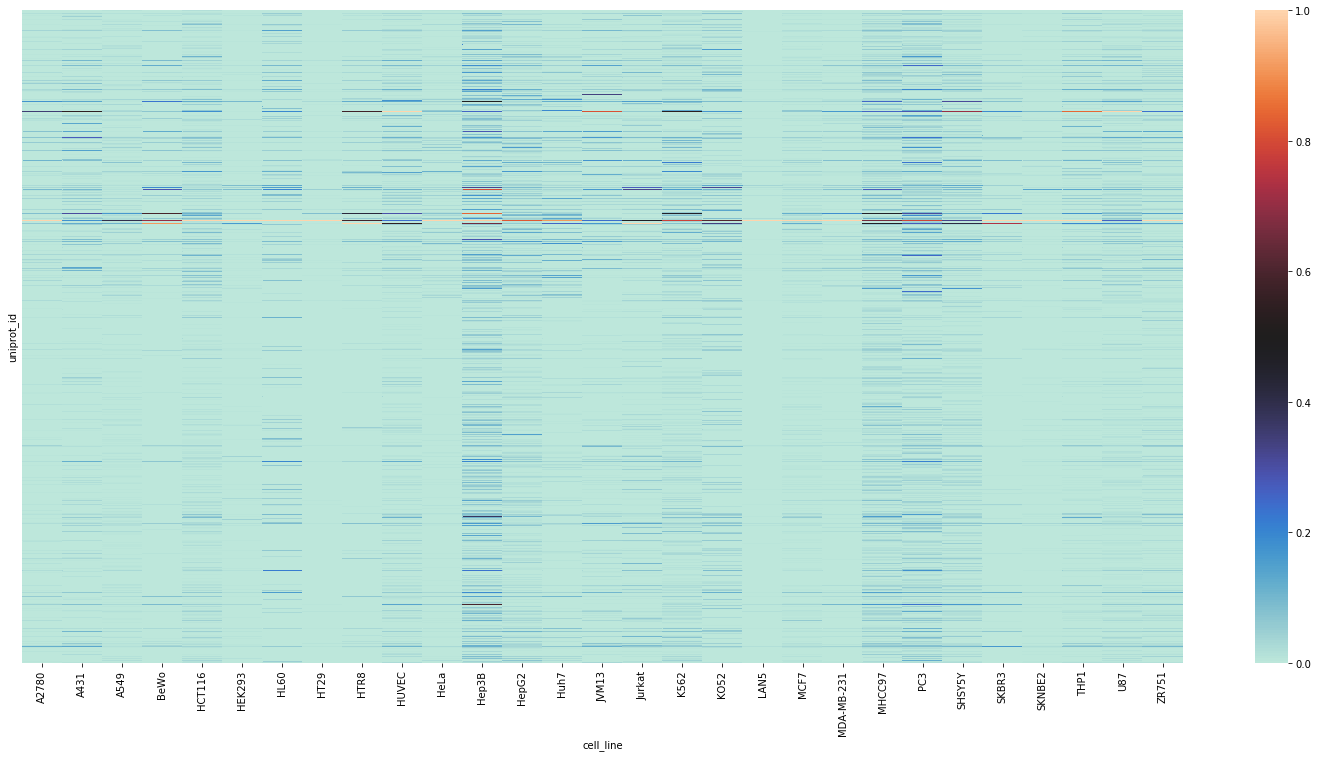

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
fig, ax = plt.subplots(figsize=(26,12))
datamap = sns.heatmap(minmax_atlas, ax=ax, yticklabels = False,cmap='icefire')
#datamap.figure.savefig('heatmap_expressionpurple0806.png')
datamap

In [33]:
# split dataset per cell
tissues = full_df['cell_line'].unique()
DataFrameDict3 = {elem : pd.DataFrame for elem in tissues}
for key in DataFrameDict3.keys():
    DataFrameDict3[key] = full_df[:][full_df['cell_line'] == key]

In [34]:
# count number of proteins for each cell
proteinCount = {}

for key in DataFrameDict3.keys():
    cell_line = DataFrameDict3[key].pop('cell_line')
    grouped = DataFrameDict3[key].groupby('uniprot_id').mean().reset_index()
    count = len(grouped.index)
    proteinCount[key] = str(count)

In [35]:

for key, val in proteinCount.items():
    print(key + ": " + val)

Hep3B: 4852
MHCC97: 5682
Jurkat: 4337
LAN5: 2191
A431: 2491
HEK293: 4079
MCF7: 6817
ZR751: 4057
JVM13: 2891
HUVEC: 4449
SKBR3: 1068
HeLa: 3265
Huh7: 2435
HCT116: 5600
K562: 5525
U87: 6083
A549: 5833
PC3: 5759
HepG2: 5395
KO52: 2530
HL60: 1623
BeWo: 1011
HTR8: 1030
SHSY5Y: 4769
MDA-MB-231: 1821
SKNBE2: 5679
A2780: 1956
HT29: 2654
THP1: 4568


## Preparing data for t-SNE analysis

In [36]:
query = "SELECT assay_id, cell_id FROM cell_to_assay"
query2 = "SELECT cell_id, cell_line, tissue_type FROM cell"
query3 = "SELECT assay_id, project_id FROM assay"
cell_assay = pd.read_sql_query(query, conn)
cell = pd.read_sql_query(query2, conn)
project = pd.read_sql_query(query3, conn)
grouped = pd.merge(cell_assay, cell, on = "cell_id")
grouped = pd.merge(grouped, project, on = "assay_id")
grouped

,assay_id,cell_id,cell_line,tissue_type,project_id
0,30960,545,Hep3B,liver,1815
1,30961,545,Hep3B,liver,1815
2,30962,545,Hep3B,liver,1815
3,30963,545,Hep3B,liver,1815
4,30964,545,Hep3B,liver,1815
...,...,...,...,...,...
4371,35319,721,KM12,colon,1895
4372,35323,721,KM12,colon,1895
4373,35327,721,KM12,colon,1895
4374,35331,721,KM12,colon,1895


In [37]:
assay_atlas = pd.pivot_table(full_df, values = 'NSAF', index = 'assay_id', columns = 'uniprot_id').fillna(0).reset_index()
assay_atlas

uniprot_id,assay_id,A0A1B0GTU1,A0A1B0GUS4,A0AV02,A0AV96,A0AVF1,A0AVK6,A0AVT1,A0FGR8,A0JLT2,...,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8
0,30960,0.0,0.000802,0.0,0.0,0.0,0.00000,0.000587,0.0,0.0,...,0.000304,0.000000,0.000000,0.0,0.000000,0.000000,0.000120,0.000000,0.0,0.000000
1,30961,0.0,0.000749,0.0,0.0,0.0,0.00000,0.000767,0.0,0.0,...,0.000426,0.000000,0.000000,0.0,0.000000,0.000000,0.000112,0.000000,0.0,0.000115
2,30962,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000374,0.0,0.0,...,0.000323,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,30963,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000910,0.0,0.0,...,0.000000,0.000480,0.000000,0.0,0.000000,0.000000,0.000116,0.000000,0.0,0.000000
4,30964,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000811,0.0,0.0,...,0.000000,0.000490,0.000000,0.0,0.000000,0.000291,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,32907,0.0,0.000112,0.0,0.0,0.0,0.00000,0.000457,0.0,0.0,...,0.000021,0.000276,0.000028,0.0,0.000038,0.000000,0.000017,0.000107,0.0,0.000275
855,32908,0.0,0.000111,0.0,0.0,0.0,0.00000,0.000490,0.0,0.0,...,0.000106,0.000310,0.000112,0.0,0.000038,0.000000,0.000033,0.000000,0.0,0.000223
856,32909,0.0,0.000114,0.0,0.0,0.0,0.00002,0.000519,0.0,0.0,...,0.000022,0.000319,0.000086,0.0,0.000000,0.000000,0.000034,0.000000,0.0,0.000282
857,32910,0.0,0.000224,0.0,0.0,0.0,0.00000,0.000524,0.0,0.0,...,0.000021,0.000277,0.000140,0.0,0.000038,0.000000,0.000017,0.000000,0.0,0.000172


In [38]:
atlas = pd.merge(assay_atlas, grouped, on = 'assay_id')
atlas = atlas.drop(['assay_id', 'cell_id'], axis=1)
atlas

,A0A1B0GTU1,A0A1B0GUS4,A0AV02,A0AV96,A0AVF1,A0AVK6,A0AVT1,A0FGR8,A0JLT2,A0JNW5,...,Q9Y6X4,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y1,Q9Y6Y8,cell_line,tissue_type,project_id
0,0.0,0.000802,0.0,0.0,0.0,0.00000,0.000587,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000120,0.000000,0.0,0.000000,Hep3B,liver,1815
1,0.0,0.000749,0.0,0.0,0.0,0.00000,0.000767,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000112,0.000000,0.0,0.000115,Hep3B,liver,1815
2,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000374,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,Hep3B,liver,1815
3,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000910,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000116,0.000000,0.0,0.000000,Hep3B,liver,1815
4,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000811,0.0,0.0,0.000000,...,0.0,0.000000,0.000291,0.000000,0.000000,0.0,0.000000,Hep3B,liver,1815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,0.0,0.000112,0.0,0.0,0.0,0.00000,0.000457,0.0,0.0,0.000012,...,0.0,0.000038,0.000000,0.000017,0.000107,0.0,0.000275,THP1,blood,1862
855,0.0,0.000111,0.0,0.0,0.0,0.00000,0.000490,0.0,0.0,0.000000,...,0.0,0.000038,0.000000,0.000033,0.000000,0.0,0.000223,THP1,blood,1862
856,0.0,0.000114,0.0,0.0,0.0,0.00002,0.000519,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000034,0.000000,0.0,0.000282,THP1,blood,1862
857,0.0,0.000224,0.0,0.0,0.0,0.00000,0.000524,0.0,0.0,0.000000,...,0.0,0.000038,0.000000,0.000017,0.000000,0.0,0.000172,THP1,blood,1862


In [5]:
df = pd.read_csv("proteome_nsaf_2.csv")

assay_project_query = "SELECT assay_id, project_id FROM assay"
assay_project_data = pd.read_sql_query(assay_project_query, conn)

project_query = "SELECT project_id, PXD_accession FROM project"
project_data = pd.read_sql_query(project_query, conn)

assay_cell_query = "SELECT assay_id, cell_id FROM cell_to_assay"
assay_cell_data = pd.read_sql_query(assay_cell_query, conn)

cell_query = "SELECT cell_id, cell_line, tissue_type FROM cell"
cell_data = pd.read_sql_query(cell_query, conn)

full_df = pd.merge(df, assay_project_data, on = "assay_id")

full_df = pd.merge(full_df, assay_cell_data, on = "assay_id")
full_df = pd.merge(full_df, cell_data, on = "cell_id")
full_df = pd.merge(full_df, project_data, on = "project_id")
print(full_df.columns)
metadata = full_df[["assay_id", "cell_line", "PXD_accession", "tissue_type"]]

metadata = metadata.drop_duplicates().sort_values(["assay_id"]).reset_index(drop=True)
full_df

Index(['assay_id', 'uniprot_id', 'NSAF', 'project_id', 'cell_id', 'cell_line',
       'tissue_type', 'PXD_accession'],
      dtype='object')


,assay_id,uniprot_id,NSAF,project_id,cell_id,cell_line,tissue_type,PXD_accession
0,30960,A0AV96,0.000379,1815,545,Hep3B,liver,PXD000533
1,30960,A0AVT1,0.000299,1815,545,Hep3B,liver,PXD000533
2,30960,A0FGR8,0.000244,1815,545,Hep3B,liver,PXD000533
3,30960,A0MZ66,0.000071,1815,545,Hep3B,liver,PXD000533
4,30960,A1L0T0,0.000498,1815,545,Hep3B,liver,PXD000533
...,...,...,...,...,...,...,...,...
2608617,33065,Q9Y6N5,0.000329,1872,636,CRC,colon,PXD005354
2608618,33065,Q9Y6W5,0.000297,1872,636,CRC,colon,PXD005354
2608619,33065,Q9Y6X5,0.000653,1872,636,CRC,colon,PXD005354
2608620,33065,Q9Y6X9,0.000143,1872,636,CRC,colon,PXD005354


In [6]:
assay_atlas = pd.pivot_table(full_df, values = 'NSAF', index = 'assay_id', columns = 'uniprot_id').fillna(0).reset_index()
atlas = pd.merge(assay_atlas, metadata, on = 'assay_id')
atlas

,assay_id,A0A024RBG1,A0A075B6H7,A0A075B6I1,A0A075B6I3,A0A075B6L6,A0A075B6N1,A0A075B6R9,A0A075B6V5,A0A075B6X5,...,Q9Y6Y8,Q9Y6Y9,Q9Y6Z4,Q9Y6Z5,Q9Y6Z7,W5XKT8,W6CW81,cell_line,PXD_accession,tissue_type
0,30960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000180,0.0,0.0,0.0,0.0,0.0,0.0,Hep3B,PXD000533,liver
1,30961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000216,0.0,0.0,0.0,0.0,0.0,0.0,Hep3B,PXD000533,liver
2,30962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Hep3B,PXD000533,liver
3,30963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Hep3B,PXD000533,liver
4,30964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,Hep3B,PXD000533,liver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,34107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,KM12,PXD005940,colon
1939,34108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,CCRF-CEM,PXD005940,T-cell
1940,34109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,CCRF-CEM,PXD005940,T-cell
1941,34110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,CCRF-CEM,PXD005940,T-cell


In [7]:
atlas.to_csv('tsne_atlas3.csv', index=False)